# Semantic Segmentation on CityScapes Dataset

In this notebook, I do pixel-level semantic segmentation on the CityScapes Dataset where the [state-of-the-art mIOU (for classes) is 85.8](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task). In this notebook, I walk through the process of training a UNET+ResNet34 architecture for 10 epochs with and without progressive resizing using the [fastai (v2) library](https://docs.fast.ai/).

In [3]:
from sklearn.metrics import confusion_matrix
from fastai.vision.all import *
from fastai.metrics import Metric
import cityscapesscripts as cs
from cityscapesscripts.helpers.labels import labels
CUDA_LAUNCH_BLOCKING=1 # show CUDA errors in depth

### Define mIOU metric

Benchmark for pixel-level semantic segmentation is based on mean Intersection over Union (mIOU) metric. This is adapted from the [blog post by Zachary Mueller on CAMVID segmentation](https://muellerzr.github.io/fastblog/papers/2020/09/19/CAMVID.html). My contribution is to customize the metric class by passing in list of valid labels/classes to [scikit-learn's confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [4]:
class MIOUValid(AvgMetric):
    "Mean Intersection over Union Metric"
    def __init__(self, valid_classes, axis):
        store_attr()

    def accumulate(self, learn):
        pred, targ = learn.pred.argmax(dim=self.axis).cpu(), learn.y.cpu()
        pred, targ = pred.flatten().numpy(), targ.flatten().numpy()
        self.total += confusion_matrix(targ, pred, labels=self.valid_classes)

    @property
    def value(self): 
        conf_matrix = self.total
        per_class_TP = np.diagonal(conf_matrix).astype(float)
        per_class_FP = conf_matrix.sum(axis=0) - per_class_TP
        per_class_FN = conf_matrix.sum(axis=1) - per_class_TP
        iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)
        iou_index = np.nan_to_num(iou_index)
        mean_iou_index = (np.mean(iou_index))    

        return mean_iou_index

    @property
    def name(self):
        return 'miou_valid'

Define Path for Dataset

In [5]:
path = Path(".")
path.ls()

(#22) [Path('.nv'),Path('leftImg8bit'),Path('.ipython'),Path('tutorials'),Path('cityscapes_semantic_segmentation_old.ipynb'),Path('license.txt'),Path('gtFine_trainvaltest.zip'),Path('.config'),Path('models'),Path('.local')...]

### Specify class labels and valid codes

In [6]:
# Loading class labels
id2name = {name.id: name for name in labels}
#print(id2name)

codes = [name.name for name in labels]
#print(codes)

codes_dict = {idx:name for idx, name in enumerate(codes)}
# print(codes_dict)

Valid codes are those that should not be ignored for evaluation

In [7]:
valid_codes = [label.id for label in labels if not label.ignoreInEval]
len(valid_codes)
print(valid_codes)

[7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]


### View Sample Image and Extract Image Size

In [8]:
fnames = get_image_files(path/"leftImg8bit")
len(fnames) # as expected

5000

<AxesSubplot:>

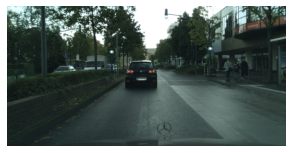

In [9]:
im = Image.open(fnames[0])
show_image(im)

In [10]:
original_height, original_width = im.shape

In [11]:
original_height, original_width

(1024, 2048)

## Defining Data Loaders

In [12]:
# Define label function to locate images with masks/labels
def label_func(fn):
    label_fn = str(fn).replace('leftImg8bit', 'gtFine')[:-4] + "_labelIds.png"
    #label_fn = str(fn).replace('leftImg8bit', 'gtFine')[:-4] + "_color.png"
    return Path(label_fn)

Because of compute constraints (i.e. GPU memory), the largest image size I can use for training is one-third the size of the original image size.

In [13]:
third = (original_height//3, original_width//3)
third

(341, 682)

Define DataLoaders and show batch of images with mask overlaid on top of image.

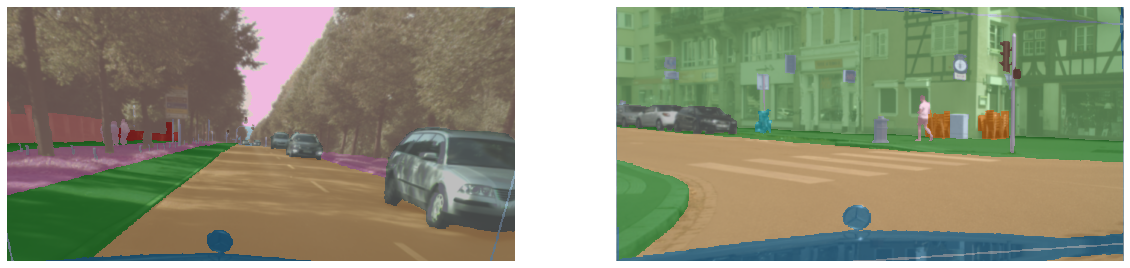

In [14]:
item_tfms = [Resize(third)]
batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]

cityscapes = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                 get_items = get_image_files,
                 get_y = label_func,
                 splitter = GrandparentSplitter(train_name="train", valid_name="val"),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms
)
dls = cityscapes.dataloaders(source=path/"leftImg8bit", bs=4)
dls.show_batch(max_n=2, figsize=(20,20))

## Defining Model

I use a U-NET model built on top of a ResNet3 architecture, which is known to be good for training on image segmentation problems. 

Use of Leslie Smith's [learning rate finder](https://arxiv.org/abs/1506.01186) to find the optimal learning rate.

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=0.0002290867705596611)


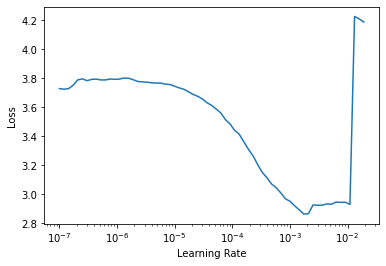

In [15]:
learn = unet_learner(dls, resnet34, metrics=[MIOUValid(valid_codes, axis=1)])
lr = learn.lr_find() # learning rate finder
print(lr)

## Training the Model

Train for 10 epochs using the learning rate found above.

In [16]:
num_epochs = 10
learn.fine_tune(epochs=num_epochs, base_lr=lr[1])

epoch,train_loss,valid_loss,miou_valid,time
0,0.739524,0.764957,0.267195,07:38


epoch,train_loss,valid_loss,miou_valid,time
0,0.560173,0.581119,0.392879,07:56
1,0.534642,0.548990,0.392638,07:55
2,0.516611,0.516655,0.402123,07:55
3,0.428671,0.459566,0.489115,07:55
4,0.435339,0.445990,0.505164,07:56
5,0.376802,0.428590,0.539553,07:56
6,0.369986,0.412703,0.563938,07:57
7,0.347279,0.412520,0.582430,07:56
8,0.329026,0.413551,0.591808,07:56
9,0.304177,0.415092,0.591417,07:57


### Show sample results as targets (left) vs. predictions (right)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


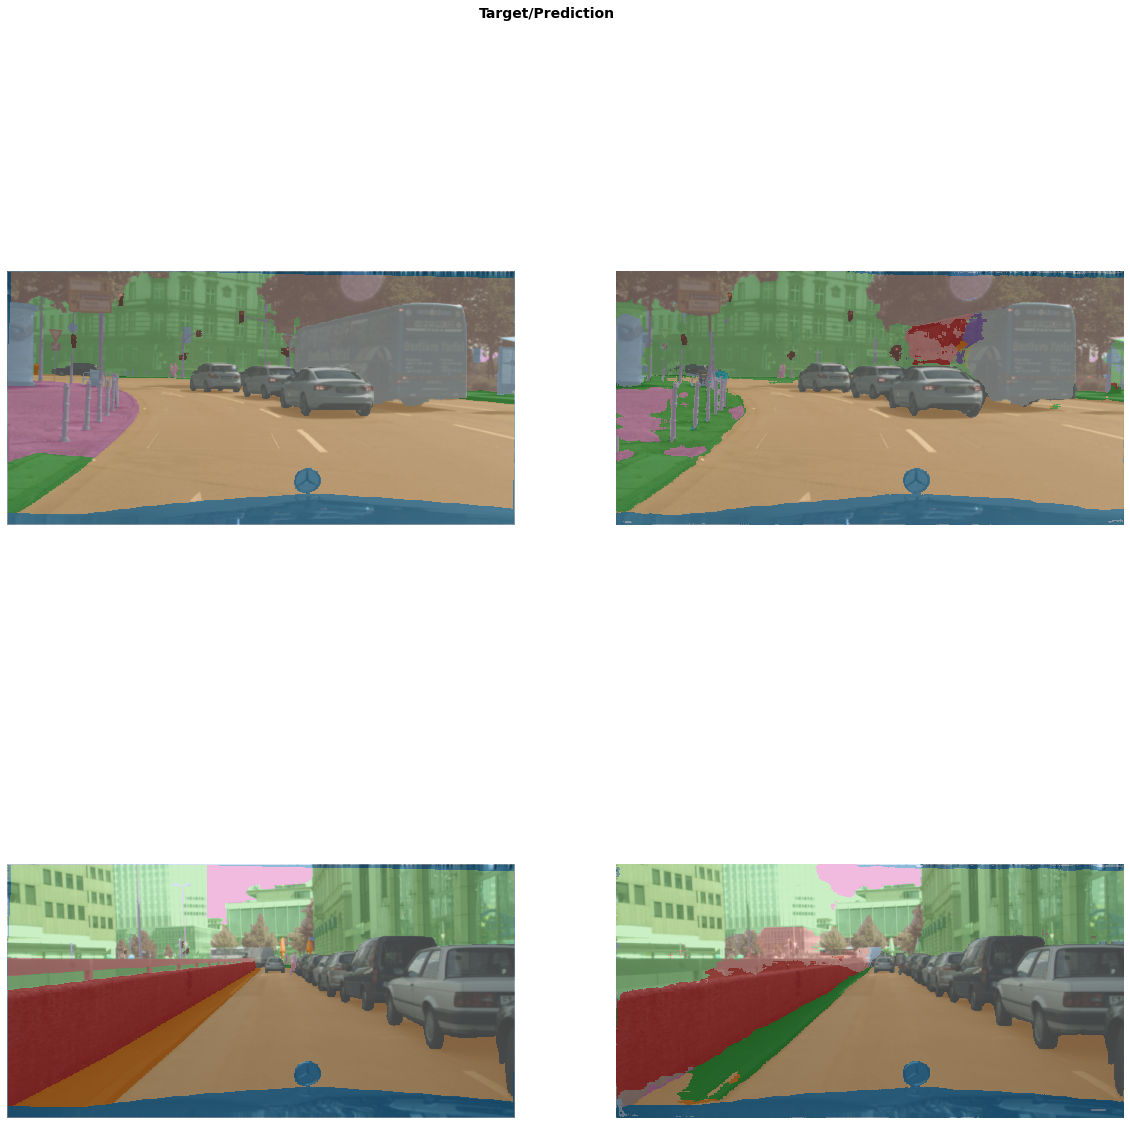

In [17]:
learn.show_results(max_n=4, figsize=(20,20))

In [18]:
learn.save("simple_unet_learner")
assert (path/'models/simple_unet_learner.pth').exists()

## Progressive Resizing

This is involves spending some of the epochs training with smaller images to help the training complete faster while completing the training using larger images to make the final accuracy higher. I will train 5 of the epochs with smaller images (i.e., one-fourth of the original image size) and train the remaining 5 epochs with larger images (i.e., one-third of the original image size). 

Run Cell Below to Free Up GPU Memory

In [19]:
# Free up memory
del learn
del cityscapes
del dls
torch.cuda.empty_cache()
import gc
gc.collect()

31587

Define smaller image size for progressive resizing

In [21]:
fourth = (original_height//4, original_width//4)
fourth

(256, 512)

Define function to easily redefine DataLoaders for different image sizes

In [27]:
def get_dls(size):
    
    if size == fourth:
        # downscale and then upscale the images
        item_tfms = [Resize(fourth), Resize(third)]
    elif size == third:
        item_tfms = [Resize(third)]
    
    batch_tfms=[*aug_transforms(size=size), Normalize.from_stats(*imagenet_stats)]

    cityscapes = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                     get_items = get_image_files,
                     get_y = label_func,
                     splitter = GrandparentSplitter(train_name="train", valid_name="val"),
                     item_tfms=item_tfms,
                     batch_tfms=batch_tfms
    )
    
    return cityscapes.dataloaders(source=path/"leftImg8bit", bs=4)

epoch,train_loss,valid_loss,miou_valid,time
0,0.731203,0.740652,0.278353,04:20
1,0.559343,0.608484,0.356474,04:20
2,0.500156,0.525420,0.411704,04:20
3,0.430435,0.469100,0.462857,04:20
4,0.419287,0.455710,0.490380,04:20


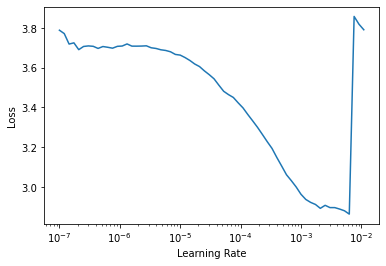

In [28]:
dls = get_dls(fourth)
learn = unet_learner(dls, resnet34, metrics=[MIOUValid(valid_codes, axis=1)])
lr = learn.lr_find() # learning rate finder
learn.fit_one_cycle(5, lr[1])

Replace `DataLoaders` inside the `Learner` and fine-tune (with learning rate finder)

epoch,train_loss,valid_loss,miou_valid,time
0,0.435374,0.454963,0.505850,07:39


epoch,train_loss,valid_loss,miou_valid,time
0,0.433936,0.453867,0.506565,07:56
1,0.402882,0.449260,0.507495,07:57
2,0.414532,0.446252,0.506726,07:57
3,0.416994,0.446458,0.507436,07:57
4,0.419708,0.445546,0.507196,07:57


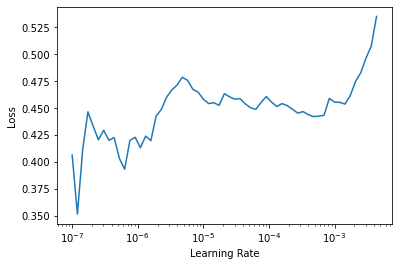

In [29]:
learn.dls = get_dls(third)
lr = learn.lr_find() # learning rate finder
learn.fine_tune(5, lr[1])

#### Show sample results as targets (left) vs. predictions (right)

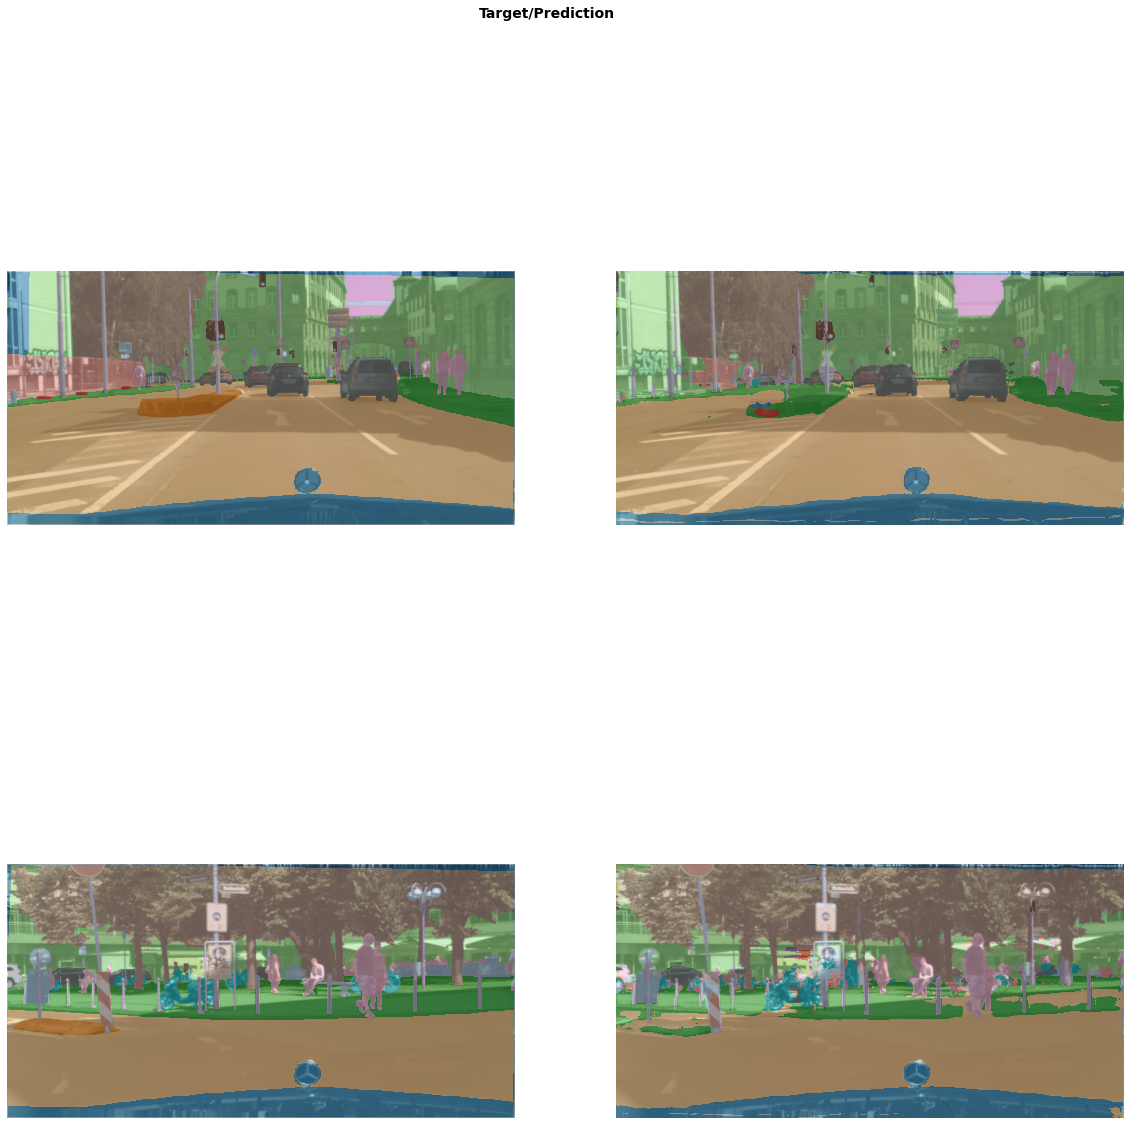

In [30]:
learn.show_results(max_n=4, figsize=(20,20))

In [32]:
learn.save("progressive_resizing_unet_learner")
assert (path/'models/progressive_resizing_unet_learner.pth').exists()

### Possible Areas for Model Improvement

* More progressive resizing steps (possibly enabled by more compute/memory)
* Additional item and batch augmentations
* Use of Mish (instead of ReLU) on Dynamic UNET head along with `ranger` optimizer
* Trans